<a href="https://colab.research.google.com/github/Malhinova/Kaggle-Competition/blob/main/notebook4aa02ce91f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tabular-playground-series-jul-2021:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F28007%2F2425957%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240423%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240423T134243Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D98f922d9e40245b0b02aa59045b84ed9ad2ffc1328945f2fc003ae03d471be3e85e69f4728813d0c0ba5b69daaa023d61cab6cd43b32603710d6fbb754253bb7844250e9efd7158bffce1b19cb7b510ea788ad8ff10ec288cfef06cf16887c78967cb74eb888f7e0cd2c6a3bbf12fa7d4d30dc16445b8b603400dfeb14539cbf519946b8c74f187fb23e9411094284f7f53ca7254cca71d53bd3b49c65b293d328920ca4925e93d0e4ec54db1ee14776685858394ff6e42a390e23701712e6074029149127a3ba54146fc7caa828b26cb560f5c1a9a8e6eddad5d18d20f8dac73d2c2b531028e4df4b2e244585a79a4167349faeaf10d3854c9eb3d94a045a94'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 270437 bytes downloaded
Downloaded and uncompressed: tabular-playground-series-jul-2021
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jul-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2021/test.csv
/kaggle/input/tabular-playground-series-jul-2021/train.csv


In [3]:
import os, shutil

import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import random
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
data=pd.read_csv('/kaggle/input/tabular-playground-series-jul-2021/train.csv')
data.head()


,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8


In [5]:
date_time_column = data['date_time']
targets=['target_carbon_monoxide','target_benzene','target_nitrogen_oxides']
# for row in targets:
#     plt.figure(figsize=(8, 6))
#     sns.scatterplot(y= data[row],x=date_time_column )
#     plt.show()

In [6]:
data_copy=data.copy()
data_copy['date_time'] = pd.to_datetime(data_copy['date_time'])
data_copy['month'] = data_copy['date_time'].dt.month
data_copy['day'] = data_copy['date_time'].dt.day
data_copy['hour'] = data_copy['date_time'].dt.hour
data_copy['day_week'] = data_copy['date_time'].dt.day_of_week



In [7]:
def find_hour(hour):
    if (hour>=0 and hour<6):
        return 1 #Night
    if hour>=6 and hour<12:
        return 2 #Morning
    if hour>=12 and hour<18:
        return 3 #Day
    if hour>=18 and hour<24:
        return 4 #Evening

In [8]:
hour_list=[]
for hour in data_copy['hour']:
    part_day = find_hour(hour)
    hour_list.append(part_day)
data_copy['part_day']=hour_list
data_copy.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,month,day,hour,day_week,part_day
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7,3,10,18,2,4
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9,3,10,19,2,4
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1,3,10,20,2,4
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2,3,10,21,2,4
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8,3,10,22,2,4


In [9]:
columns = list(data_copy.columns)

for col in ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']:
    columns.remove(col)
columns += ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']

# Rearrange the columns in the final_data DataFrame
data_copy = data_copy[columns]
data_copy.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,month,day,hour,day_week,part_day,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,3,10,18,2,4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,3,10,19,2,4,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,3,10,20,2,4,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,3,10,21,2,4,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,3,10,22,2,4,1.5,6.4,121.8


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_n =['deg_C', 'relative_humidity', 'absolute_humidity', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']
final_data=data_copy.copy()
final_data[features_n]  = scaler.fit_transform(final_data[features_n])
final_data.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,month,day,hour,day_week,part_day,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,0.263393,0.452991,0.275071,0.522411,0.373362,0.330291,0.504003,0.446745,3,10,18,2,4,2.5,12.0,167.7
1,2010-03-10 19:00:00,0.265625,0.444444,0.259177,0.448774,0.270401,0.392990,0.379940,0.326630,3,10,19,2,4,2.1,9.9,98.9
2,2010-03-10 20:00:00,0.252232,0.577534,0.271332,0.484741,0.291757,0.332152,0.437630,0.371742,3,10,20,2,4,2.2,9.2,127.1
3,2010-03-10 21:00:00,0.216518,0.653236,0.289292,0.477316,0.291447,0.351072,0.416621,0.433905,3,10,21,2,4,2.2,9.7,177.2
4,2010-03-10 22:00:00,0.236607,0.611722,0.290326,0.443937,0.252089,0.385635,0.365369,0.378205,3,10,22,2,4,1.5,6.4,121.8


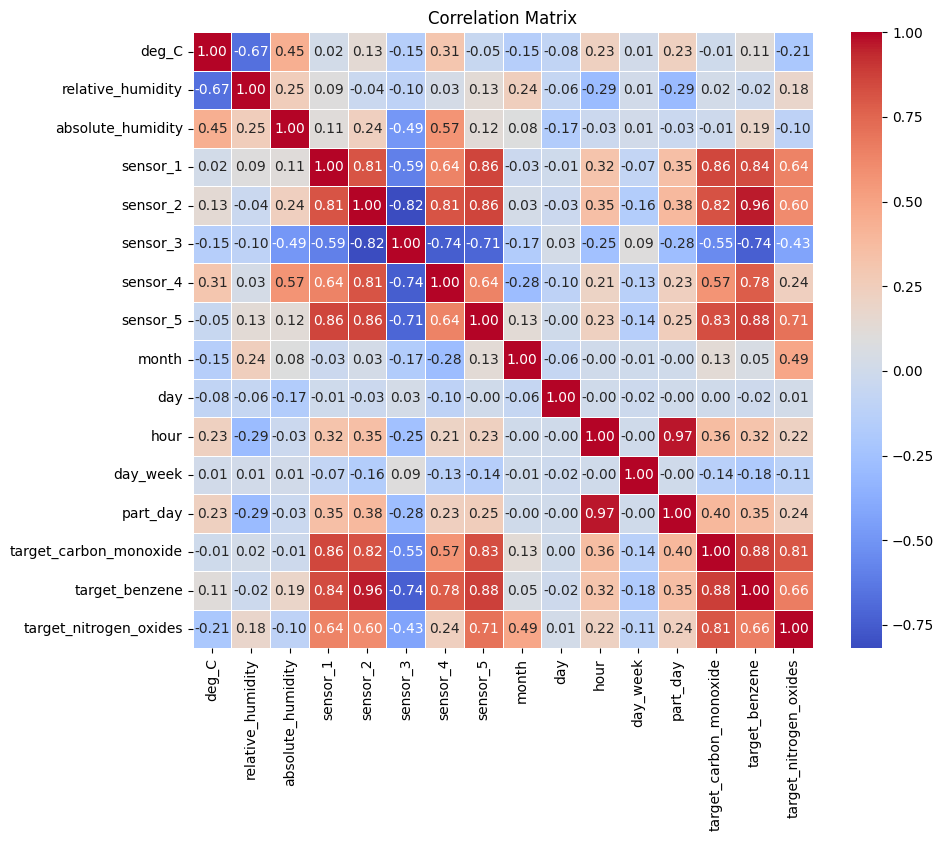

In [11]:
numeric_columns_test = final_data.select_dtypes(include=np.number).columns

correlation_matrix = final_data[numeric_columns_test].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [12]:
features_1 =['sensor_1', 'sensor_2','sensor_5', 'part_day']
features_2 =['sensor_2','sensor_5','part_day']
features_3 =['deg_C', 'relative_humidity', 'sensor_2', 'sensor_3', 'sensor_4','sensor_5']
X1=final_data[features_1]
X2=final_data[features_2]
X3=final_data[features_3]

Y = final_data[targets]
Y.head()

,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2.5,12.0,167.7
1,2.1,9.9,98.9
2,2.2,9.2,127.1
3,2.2,9.7,177.2
4,1.5,6.4,121.8


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X1, Y[targets[0]])


In [14]:
from xgboost import XGBRegressor

xgb_regressor1 = XGBRegressor(n_estimators=400, learning_rate=0.05)
xgb_regressor1.fit(X_train, y_train,
             early_stopping_rounds=5,
             eval_set=[(X_valid, y_valid)],
             verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
from sklearn.metrics import mean_absolute_error

predictions = xgb_regressor1.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

Mean Absolute Error: 0.33192980798009547


In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X2, Y[targets[1]])

In [17]:
xgb_regressor2 = XGBRegressor(n_estimators=500, learning_rate=0.01)
xgb_regressor2.fit(X_train, y_train,
             early_stopping_rounds=4,
             eval_set=[(X_valid, y_valid)],
             verbose=False)
predictions = xgb_regressor2.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Mean Absolute Error: 0.9473051500669079


In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X3, Y[targets[2]])

In [19]:
xgb_regressor3 = XGBRegressor(n_estimators=500, learning_rate=0.05)
xgb_regressor3.fit(X_train, y_train,
             early_stopping_rounds=5,
             eval_set=[(X_valid, y_valid)],
             verbose=False)
predictions = xgb_regressor3.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Mean Absolute Error: 48.36481597050773


In [20]:
test_data=pd.read_csv('/kaggle/input/tabular-playground-series-jul-2021/test.csv')
test_data.head()
date_time_column2 = test_data['date_time']

In [21]:
test_data['date_time'] = pd.to_datetime(test_data['date_time'])
test_data['month'] = test_data['date_time'].dt.month
test_data['day'] = test_data['date_time'].dt.day
test_data['hour'] = test_data['date_time'].dt.hour
test_data['day_week'] = test_data['date_time'].dt.day_of_week
test_data.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,month,day,hour,day_week
0,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1,1,1,0,5
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0,1,1,1,5
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8,1,1,2,5
3,2011-01-01 03:00:00,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0,1,1,3,5
4,2011-01-01 04:00:00,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3,1,1,4,5


In [22]:
hour_list=[]
for hour in test_data['hour']:
    part_day = find_hour(hour)
    hour_list.append(part_day)
test_data['part_day']=hour_list
test_data.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,month,day,hour,day_week,part_day
0,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1,1,1,0,5,1
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0,1,1,1,5,1
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8,1,1,2,5,1
3,2011-01-01 03:00:00,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0,1,1,3,5,1
4,2011-01-01 04:00:00,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3,1,1,4,5,1


In [23]:
features_n =['deg_C', 'relative_humidity', 'absolute_humidity', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']
test_data[features_n]  = scaler.fit_transform(test_data[features_n])
test_data.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,month,day,hour,day_week,part_day
0,2011-01-01 00:00:00,0.299694,0.398734,0.209220,0.363928,0.274315,0.288235,0.211256,0.443916,1,1,0,5,1
1,2011-01-01 01:00:00,0.211009,0.530380,0.224861,0.479540,0.358265,0.222249,0.266232,0.629558,1,1,1,5,1
2,2011-01-01 02:00:00,0.232416,0.527848,0.235206,0.358833,0.367491,0.225754,0.247927,0.455579,1,1,2,5,1
3,2011-01-01 03:00:00,0.207951,0.537975,0.235538,0.389318,0.394394,0.245030,0.288863,0.448084,1,1,3,5,1
4,2011-01-01 04:00:00,0.192661,0.603797,0.231979,0.292933,0.339672,0.333192,0.262796,0.388842,1,1,4,5,1


In [24]:

X1=test_data[features_1]
X2=test_data[features_2]
X3=test_data[features_3]
X1.head()

,sensor_1,sensor_2,sensor_5,part_day
0,0.363928,0.274315,0.443916,1
1,0.479540,0.358265,0.629558,1
2,0.358833,0.367491,0.455579,1
3,0.389318,0.394394,0.448084,1
4,0.292933,0.339672,0.388842,1


In [25]:
out1=xgb_regressor1.predict(X1)
out2=xgb_regressor2.predict(X2)
out3=xgb_regressor3.predict(X3)
output_df = pd.DataFrame({
    'date_time': date_time_column2,
    'target_carbon_monoxide': out1,
    'target_benzene': out2,
    'target_nitrogen_oxides': out3
})

output_df.head()


,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.979451,8.446957,301.273499
1,2011-01-01 01:00:00,2.748071,12.902287,437.424683
2,2011-01-01 02:00:00,2.577639,12.710383,449.337036
3,2011-01-01 03:00:00,2.675292,14.087216,480.632843
4,2011-01-01 04:00:00,1.915249,10.995173,357.158112


In [26]:
# import numpy as np
# import xgboost as xgb

# # Define the parameters for XGBoost models
# xgb_params = {
#     'objective': 'reg:squarederror',  # Use regression objective function
#     'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
#     'max_depth': 6,  # Maximum depth of a tree
#     'learning_rate': 0.1,  # Learning rate
#     'n_estimators': 1000,  # Number of boosting rounds
#     'subsample': 0.8,  # Subsample ratio of the training instances
#     'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
#     'random_state': None  # Different seed for each model
# }

# # Initialize a list to store XGBoost models
# xgb_models = []

# # Create 3 XGBoost models, one for each target
# for target in targets:
#     # Initialize XGBoost regressor
#     xgb_regressor = xgb.XGBRegressor(**xgb_params)
#     # Train the XGBoost model on the training data for the current target
#     xgb_regressor.fit(X_train, y_train[target])
#     # Append the trained model to the list
#     xgb_models.append(xgb_regressor)

# # Predictions from each XGBoost model
# all_predictions = np.zeros((len(X_test), len(targets)))

# # Make predictions using each XGBoost model and store them
# for i, model in enumerate(xgb_models):
#     predictions = model.predict(X_test)
#     all_predictions[:, i] = predictions

# # Compute RMSE for each target separately
# rmse = np.sqrt(np.mean((y_test - all_predictions) ** 2, axis=0))
# for i, target in enumerate(targets):
#     print(f"RMSE for {target}: {rmse[i]}")

In [27]:
output_df.shape

(2247, 4)

In [28]:
output_df.to_csv('submission.csv', index=False)

In [29]:
# predicted_df.shape

In [30]:
# predicted_df.to_csv('submission.csv', index=False)